In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits

In [8]:
def read_fits_file(filename):
    with fits.open(filename) as hdul:
        data = hdul[1].data
        time = data['TIME']
        rate = data['RATE']
        rate_error = data['ERROR']
    print("reading fits...")
    return time, rate, rate_error

def bin_light_curve(time, rate, rate_error, period, num_phase_bins):
    phase = (time % period) / period
    phase_bins = np.linspace(0, 1, num_phase_bins + 1)
    folded_rate = np.zeros(num_phase_bins)
    folded_rate_error = np.zeros(num_phase_bins)

    for i in range(num_phase_bins):
        bin_indices = np.where((phase >= phase_bins[i]) & (phase < phase_bins[i+1]))[0]
        if len(bin_indices) > 0:
            folded_rate[i] = np.mean(rate[bin_indices])
            folded_rate_error[i] = np.sqrt(np.sum(rate_error[bin_indices]**2)) / len(bin_indices)
    print("Doing binning: ",i)
    return phase_bins, folded_rate, folded_rate_error

def compute_rms_per_phase_bin(time, rate, rate_error, period, num_phase_bins):
    phase = (time % period) / period
    phase_bins, folded_rate, folded_rate_error = bin_light_curve(time, rate, rate_error, period, num_phase_bins)
    
    rms_values = np.zeros(num_phase_bins)
    total_segments = len(time) // num_phase_bins
    
    """Aru Ma'am implementation"""
    # if len(bin_flux) > 0:
    #         mean_flux = np.mean(bin_flux)
    #         mean_flux_error = np.mean(bin_flux_error)
    #         squared_flux_deviation = (bin_flux - mean_flux) ** 2
    #         rms = (np.sqrt(np.mean(squared_flux_deviation)))
    #         squared_error_deviation = bin_flux_error ** 2
    #         rms_error = (np.sqrt(np.mean(squared_error_deviation)) / np.sqrt(len(bin_flux)))


    for i in range(num_phase_bins):
        phase_bin_indices = np.where((phase >= phase_bins[i]) & (phase < phase_bins[i+1]))[0]
        if len(phase_bin_indices) > 0:
            mean_folded_rate = folded_rate[i]
            N = len(phase_bin_indices) 
            mean_error = np.mean(rate_error[phase_bin_indices])

            rms_numerator = np.sum((rate[phase_bin_indices]- mean_folded_rate) ** 2)
            error_contribution = (N * mean_error**2)  
            rms_values[i] = np.sqrt((rms_numerator - error_contribution) / N) / np.mean(rate)
            #Aru ma'am's expression
            #rms_values[i]=np.sqrt(rms_numerator/N)
        else:
            rms_values[i]=0
    print("Rms and folded rate done...")        
    return rms_values,folded_rate,folded_rate_error

In [9]:
def plot_rms_values_multiple_files(rms_values_list, num_bins=64):
    # Determine the total number of light curves
    num_files = len(rms_values_list)
    num_segments = num_files  # One segment per light curve file

    num_cols = 2
    num_rows = np.ceil(num_segments / num_cols).astype(int)

    fig, axs = plt.subplots(num_rows, num_cols, figsize=(15, 4 * num_rows))
    axs = axs.flatten()
    # Plot the RMS values for each light curve file
    for i in range(num_files):
        rms_values = rms_values_list[i]
        #Plotting two times the phase
        rms_values_2x = np.concatenate((rms_values, rms_values))
        phase_2x_norm = np.linspace(0, 2,len(rms_values_2x), endpoint=False)
        axs[i].plot(phase_2x_norm, rms_values_2x,"-o")
        axs[i].set_title(f'Light Curve {i+1}')
        axs[i].set(xlabel='Phase Bin', ylabel='RMS')

    # Hide any unused subplots if there are more axes than light curves
    for i in range(num_files, len(axs)):
        axs[i].set_visible(False)

    # Adjust layout for better spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_rms_and_folded_light_curve_save_fits(rms_values_list, folded_rate_list,folded_rate_error_list, num_bins=64):
    num_files = len(rms_values_list)
    
    fig, axs = plt.subplots(num_files * 2, 1, figsize=(12, 8 * num_files))

    axs = axs.flatten()

    for i in range(num_files):
        rms_values = rms_values_list[i]
        rms_values_2x = np.concatenate((rms_values, rms_values)) 



        #phase_2x_norm = np.linspace(0, 2, len(rms_values_2x), endpoint=False)
        phase_2x_norm = (np.linspace(0, 2, len(rms_values_2x) + 1)[:-1] + np.linspace(0, 2, len(rms_values_2x) + 1)[1:]) / 2

        ax_rms = axs[i * 2]  
        ax_rms.plot(phase_2x_norm, rms_values_2x, "-o", color="blue")
        ax_rms.set_title(f'RMS for Light Curve {i+1}')
        ax_rms.set_ylabel('Normalized RMS')
        ax_rms.set_xlabel('Phase')

        folded_rate = folded_rate_list[i]
        folded_rate_error=folded_rate_error_list[i]
        folded_rate_2x = np.concatenate((folded_rate, folded_rate))
        folded_rate_error_2x = np.concatenate((folded_rate_error, folded_rate_error))
        ax_folded = axs[i * 2 + 1]  
        ax_folded.errorbar(phase_2x_norm, folded_rate_2x,yerr=folded_rate_error_2x, fmt="-o", color="red",alpha=0.7)
        ax_folded.set_title(f'Folded Light Curve {i+1}')
        ax_folded.set_ylabel('Relative Intensity')
        ax_folded.set_xlabel('Phase')
    plt.tight_layout()
    plt.savefig('./rms_calc/lc_v_rms.png')

    plt.show()

In [6]:
lc_files = [
    './6050390201/xti/event_cl/ni6050390201_cl_night_barycorrmpu7_sr_night.lc',
    './6050390204nn/xti/event_cl/ni6050390204_cl_night_barycorrmpu7_sr_night.lc',
    './6050390227nn/xti/event_cl/ni6050390227_cl_night_barycorrmpu7_sr_night.lc',
    './6050390244nn/xti/event_cl/ni6050390244_cl_night_barycorrmpu7_sr_night.lc',
    './6050390261nn/xti/event_cl/ni6050390261_cl_night_barycorrmpu7_sr_night.lc',
    './6050390284nn/xti/event_cl/ni6050390284_cl_night_barycorrmpu7_sr_night.lc'
]

periods = np.array([9.8082, 9.8039, 9.7990, 9.8009, 9.7890, 9.7722])
phase_bins = [64, 64, 64, 64, 64, 64]

rms_values_list = []
folded_rate_list=[]
folded_rate_error_list=[]
i=1
for lc, period, num_bins in zip(lc_files, periods, phase_bins):
    time, rate, rate_error = read_fits_file(lc)
    # Compute the RMS values for each phase bin
    rms_values,folded_rate,folded_rate_error = compute_rms_per_phase_bin(time-time[0], rate, rate_error, period, num_bins)
    plt.plot(np.linspace(0,1,num_bins),rms_values,'-o')
    plt.title('rms normalized vs phase')
    plt.xlabel('phase(0-1)')
    plt.ylabel('RMS/Flux')
    plt.savefig(f'./rms_calc/rms_vs_phase_{i+1}.png')
    plt.close()
    i+=1
    rms_values_list.append(rms_values) #plotting rms/intensity
    folded_rate_list.append(folded_rate)
    folded_rate_error_list.append(folded_rate_error)

reading fits...
Doing binning:  63
Rms and folded rate done...
reading fits...
Doing binning:  63
Rms and folded rate done...
reading fits...
Doing binning:  63
Rms and folded rate done...
reading fits...
Doing binning:  63
Rms and folded rate done...
reading fits...
Doing binning:  63
Rms and folded rate done...
reading fits...
Doing binning:  63
Rms and folded rate done...


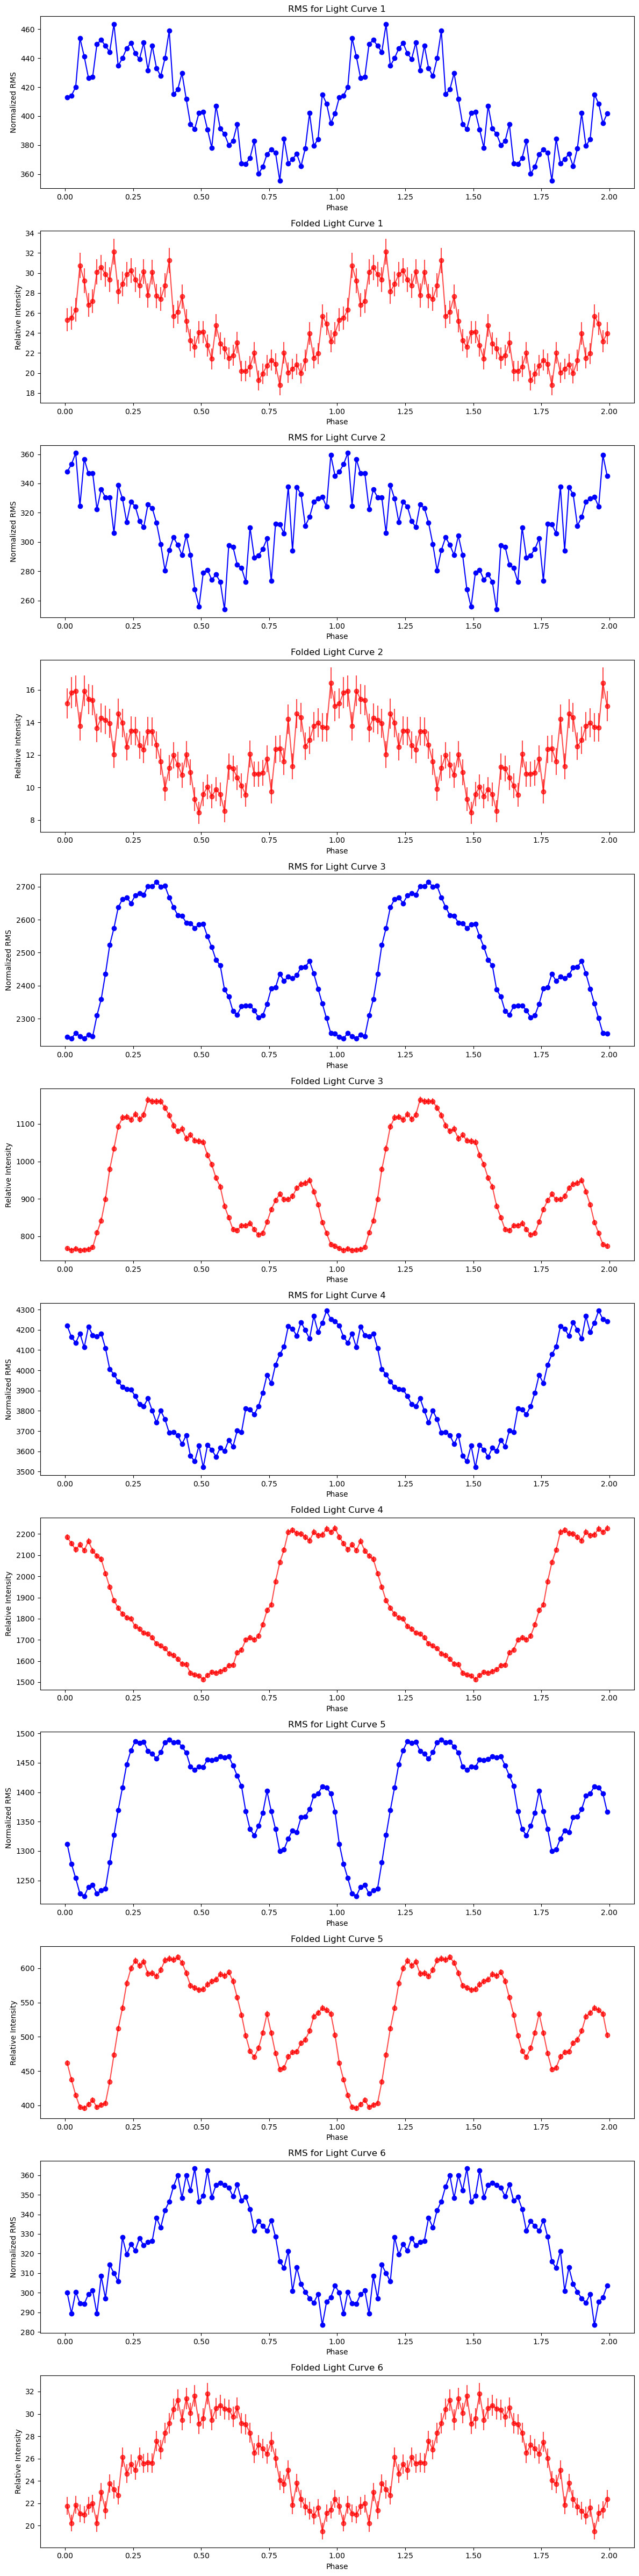

In [7]:
# Plot RMS values
#plot_rms_values_multiple_files(rms_values_list, num_bins=64)
plot_rms_and_folded_light_curve_save_fits(rms_values_list,folded_rate_list,folded_rate_error_list)

## Aru's implementation, only RMS numerator and no noise term as well

In [11]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt

def read_light_curve(file_path):
    with fits.open(file_path) as hdul:
        data = hdul[1].data
        time = data['TIME']
        flux = data['RATE']
        flux_error = data['ERROR']  # Assuming the uncertainties are stored in a column named 'ERROR'
    return time, flux, flux_error

def compute_phases(time, period):
    return (time % period) / period
   
def bin_data_by_phase(phases, flux, flux_error, num_bins):
    bin_edges = np.linspace(0, 1, num_bins + 1)
    bin_indices = np.digitize(phases, bin_edges) - 1
    phase_binned_flux = [flux[bin_indices == i] for i in range(num_bins)]
    phase_binned_flux_error = [flux_error[bin_indices == i] for i in range(num_bins)]
    return phase_binned_flux, phase_binned_flux_error

def compute_phase_resolved_rms(phase_binned_flux, phase_binned_flux_error):
    rms_values = []
    rms_errors = []

    for bin_flux, bin_flux_error in zip(phase_binned_flux, phase_binned_flux_error):
        if len(bin_flux) > 0:
            mean_flux = np.mean(bin_flux)
            mean_flux_error = np.mean(bin_flux_error)
            squared_flux_deviation = (bin_flux - mean_flux) ** 2
            rms = (np.sqrt(np.mean(squared_flux_deviation)))
            squared_error_deviation = bin_flux_error ** 2
            rms_error = (np.sqrt(np.mean(squared_error_deviation)) / np.sqrt(len(bin_flux)))
        else:
            rms = 0
            rms_error = 0

        rms_values.append(rms)
        rms_errors.append(rms_error)

    return np.array(rms_values), np.array(rms_errors)

def main(file_path, period, num_bins):
    time, flux, flux_error = read_light_curve(file_path)
    print(f"First event time: {time.min()}")
    print(f"Last event time: {time.max()}")
    print(f"Total duration: {time.max() - time.min()} seconds")

    phases = compute_phases(time, period)
    phase_binned_flux, phase_binned_flux_error = bin_data_by_phase(phases, flux, flux_error, num_bins)
    rms_values, rms_errors = compute_phase_resolved_rms(phase_binned_flux, phase_binned_flux_error)
    rms_values_2x=np.concatenate((rms_values,rms_values))
    rms_errors_2x=np.concatenate((rms_errors,rms_errors))
    mid_phase = (np.linspace(0, 2, num_bins*2 + 1)[:-1] + np.linspace(0, 2, num_bins*2 + 1)[1:]) / 2

    # Step 6: Plot the phase-resolved RMS
    plt.figure(figsize=(12,5))
    plt.errorbar(mid_phase, rms_values_2x, yerr=rms_errors_2x, fmt='-o')
    plt.xlabel('Phase')
    plt.ylabel('RMS')
    plt.title('Phase-resolved RMS-Obs2')
    #plt.savefig('Phase-resolved-RMS-Obs2.jpg')
    plt.show()
    # # Step 7: Save the results to a FITS file
    # col1 = fits.Column(name='PHASE', format='E', array=mid_phase)
    # col2 = fits.Column(name='RMS', format='E', array=rms_values)
    # col3 = fits.Column(name='RMS_ERROR', format='E', array=rms_errors)
    # hdu = fits.BinTableHDU.from_columns([col1, col2, col3])
    # hdu.writeto('phase_resolved_rms_with_errors-Obs2.fits', overwrite=True)
   
 # Prepare data for plotting flux
    avg_flux = [np.mean(bin_flux) if len(bin_flux) > 0 else 0 for bin_flux in phase_binned_flux]
    avg_flux_2x=np.concatenate((avg_flux,avg_flux))
    avg_flux_error = [np.sqrt(np.sum(bin_flux_error**2)) / len(bin_flux_error) if len(bin_flux_error) > 0 else 0 for bin_flux_error in phase_binned_flux_error]
    avg_flux_error_2x=np.concatenate((avg_flux_error,avg_flux_error))
    col1 = fits.Column(name='PHASE', format='E', array=mid_phase)
    col2 = fits.Column(name='avg_flux', format='E', array=avg_flux)
    col3 = fits.Column(name='avg_flux_error', format='E', array=avg_flux_error)

# # Create a FITS HDU (Header/Data Unit) from the columns
#     hdu = fits.BinTableHDU.from_columns([col1, col2, col3])

# # Write the FITS file
#     hdu.writeto('phase_resolved_flux_with_errors-Obs2.fits', overwrite=True)
    # Plot the phase-resolved flux
    plt.figure(figsize=(12,5))
    plt.errorbar(mid_phase, avg_flux_2x, yerr=avg_flux_error_2x, fmt='-o')
    plt.xlabel('Phase')
    plt.ylabel('Flux')
    plt.title('Phase-resolved Flux-Obs2')
    #plt.savefig('Phase-resolved-flux-Obs2.jpg')
    plt.show()

First event time: 2.100000023841858
Last event time: 2078.899749994278
Total duration: 2076.799749970436 seconds


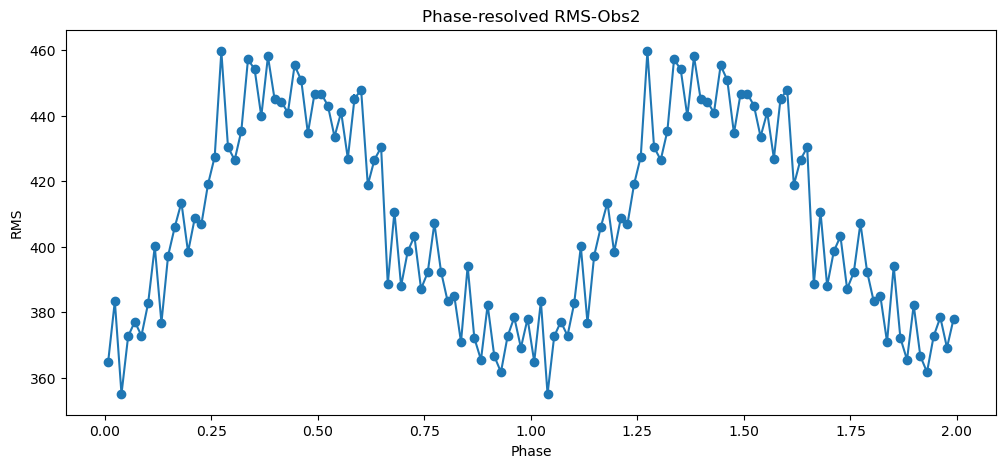

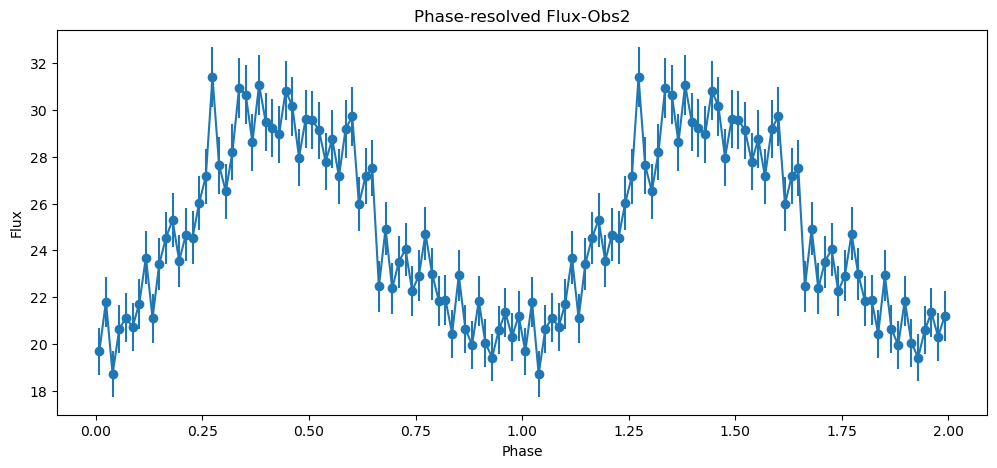

First event time: 2.100000023841858
Last event time: 67191.89974999428
Total duration: 67189.79974997044 seconds


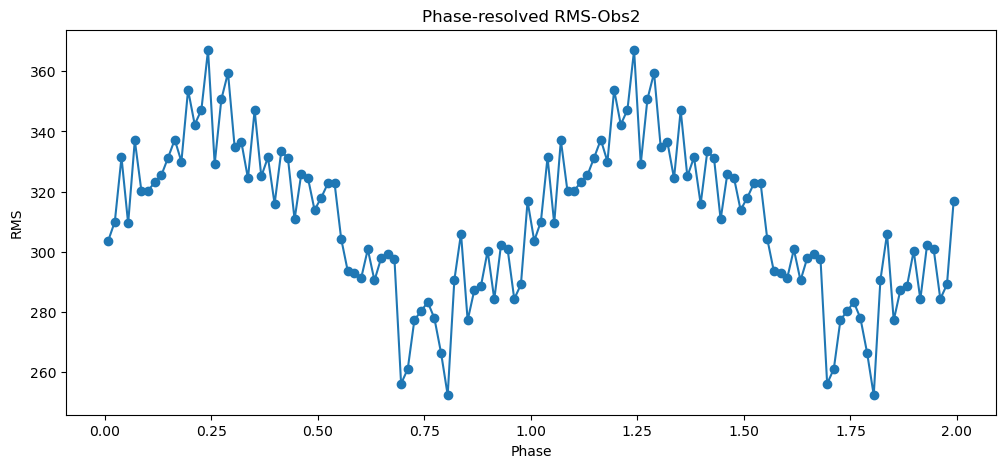

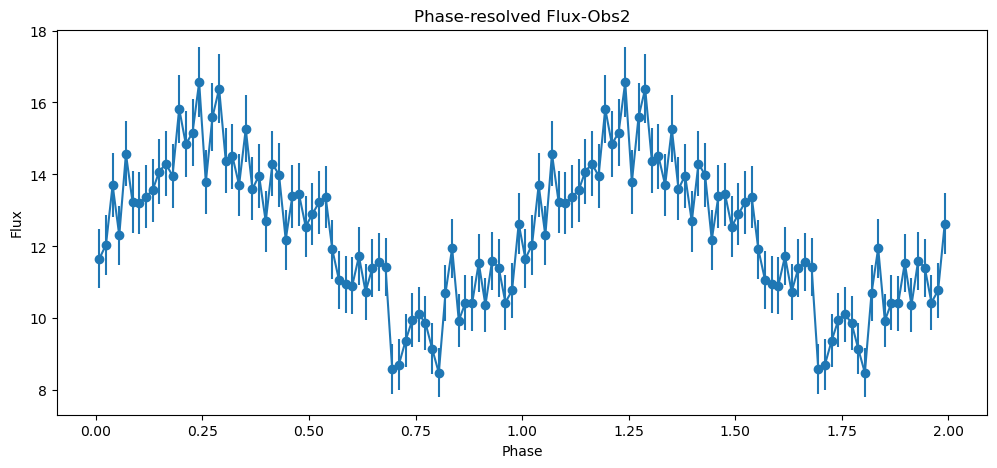

First event time: 2.100000023841858
Last event time: 33702.89974999428
Total duration: 33700.799749970436 seconds


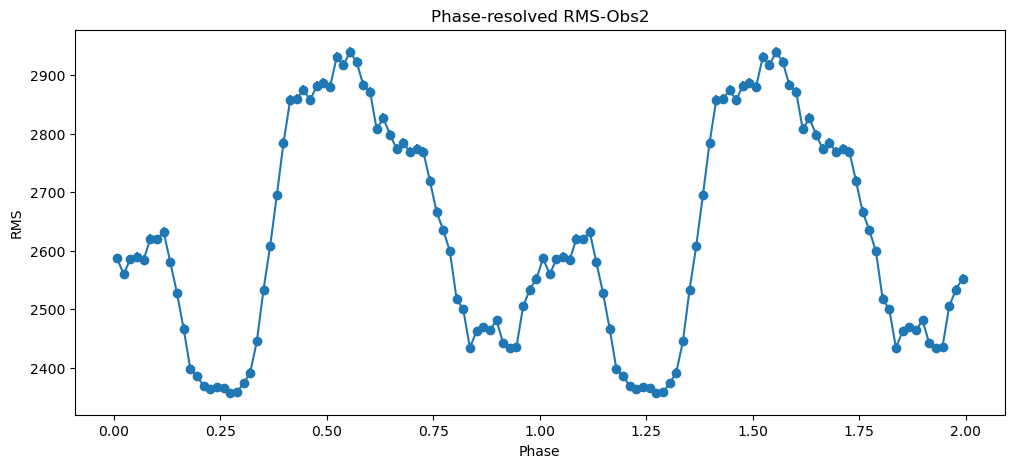

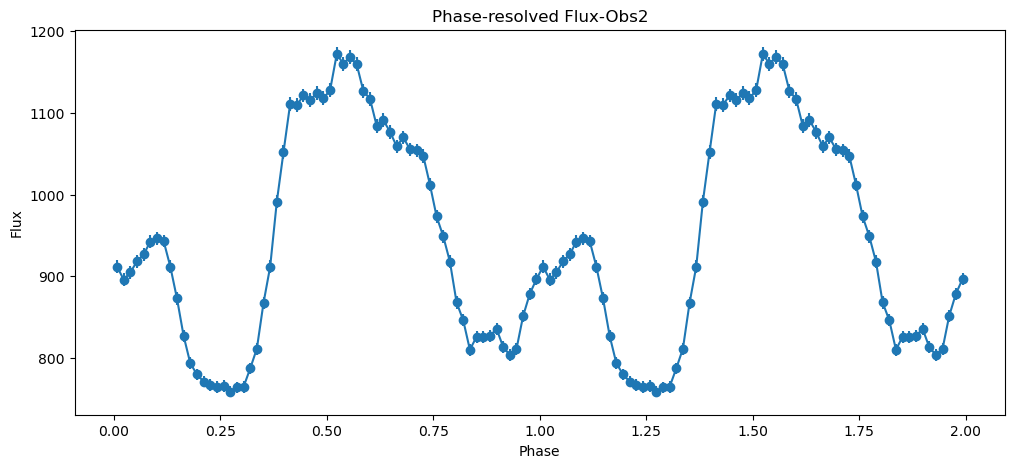

First event time: 2.100000023841858
Last event time: 44921.89974999428
Total duration: 44919.799749970436 seconds


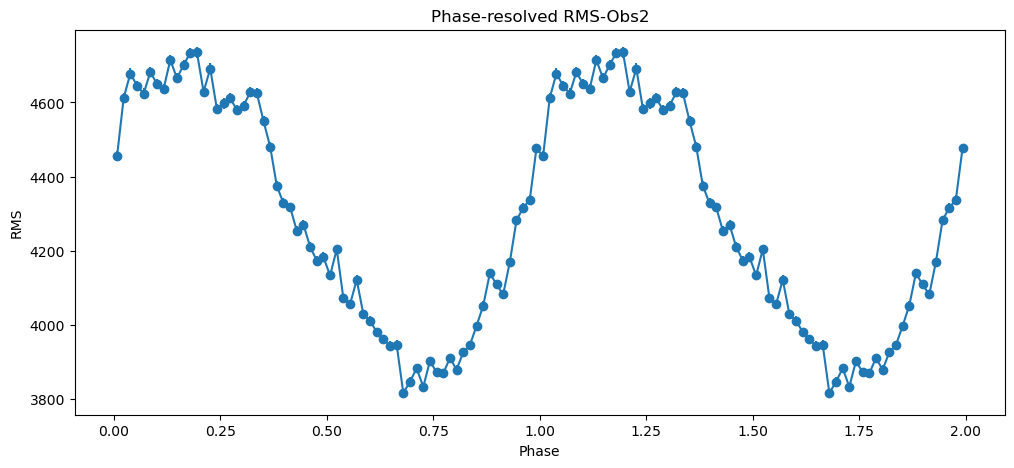

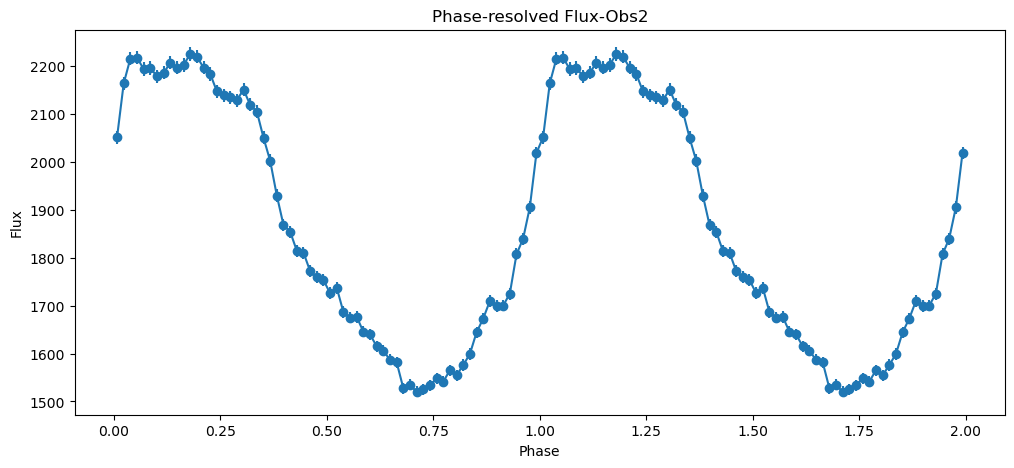

First event time: 2.100000023841858
Last event time: 67615.89974999428
Total duration: 67613.79974997044 seconds


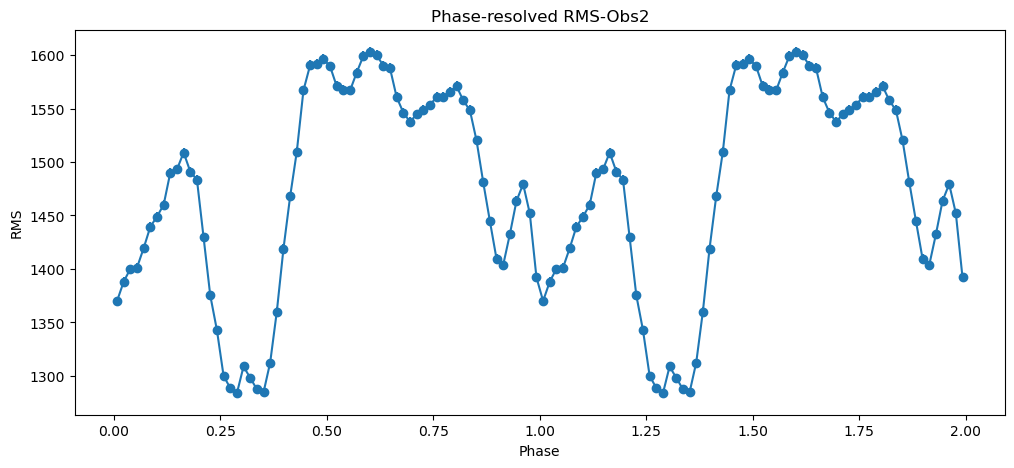

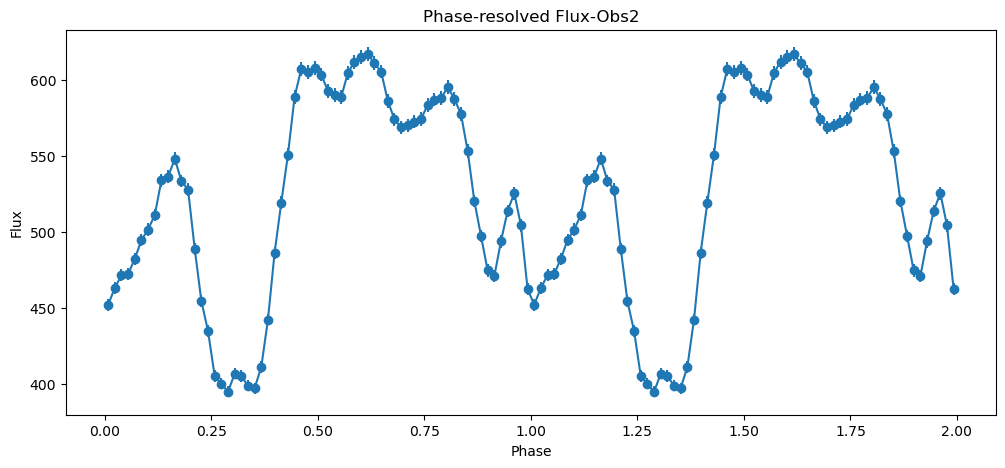

First event time: 2.100000023841858
Last event time: 39697.89974999428
Total duration: 39695.799749970436 seconds


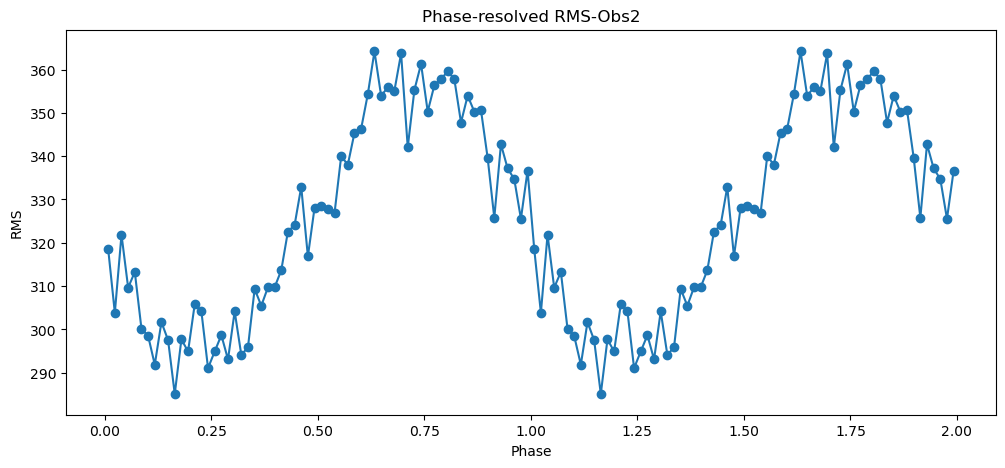

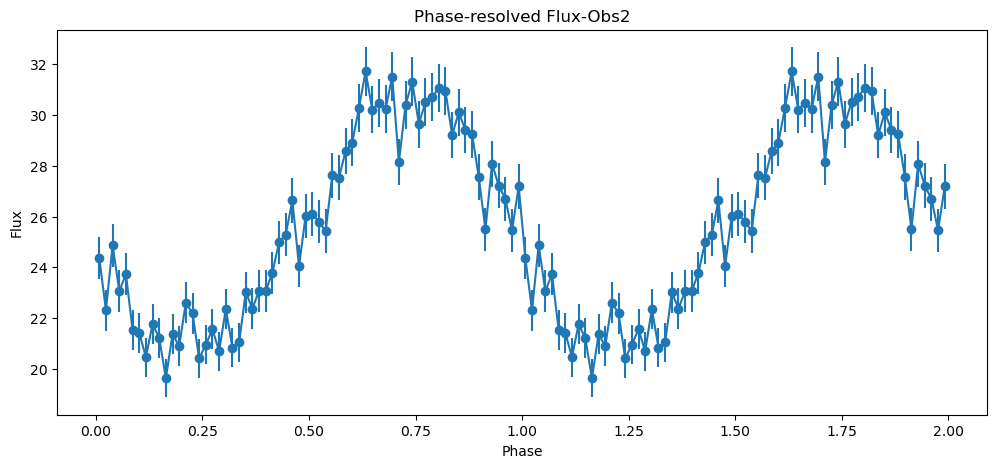

In [12]:
lc_files = [
    './6050390201/xti/event_cl/ni6050390201_cl_night_barycorrmpu7_sr_night.lc',
    './6050390204nn/xti/event_cl/ni6050390204_cl_night_barycorrmpu7_sr_night.lc',
    './6050390227nn/xti/event_cl/ni6050390227_cl_night_barycorrmpu7_sr_night.lc',
    './6050390244nn/xti/event_cl/ni6050390244_cl_night_barycorrmpu7_sr_night.lc',
    './6050390261nn/xti/event_cl/ni6050390261_cl_night_barycorrmpu7_sr_night.lc',
    './6050390284nn/xti/event_cl/ni6050390284_cl_night_barycorrmpu7_sr_night.lc'
]

periods = np.array([9.8082, 9.8039, 9.7990, 9.8009, 9.7890, 9.7722])
phase_bins = [64, 64, 64, 64, 64, 64]

for lc_file, period, phase_bin in zip(lc_files,periods,phase_bins):
    main(lc_file,period,phase_bin)